In [12]:
import pandas as pd
import numpy as np 
import time
from datetime import datetime
import math
from math import log
import scipy
import sys
from string import punctuation
from scipy import sparse
import matplotlib.pyplot as plt
from itertools import combinations
import operator
import talib 

from talib.abstract import *
import pyfolio as pf

import turtle as tl

%matplotlib inline

## 准备测试数据

In [13]:
### Load Data
### Reading 沪深300指数
data = pd.read_csv('../../data/hs300.csv', index_col='date', parse_dates=True)
data.vol = data.vol.astype(float)
start = pd.Timestamp('2005-09-01')
end = pd.Timestamp('2012-03-15')
data = data[start:end]

In [14]:
### convert trading signal to trading position and returns
def Backtest(data, signal):
    data_bt = data.ix[:,:5]
    data_bt['pred'] = signal
    data_bt.index = data_bt.index.tz_localize('UTC')
    positions = np.zeros(len(data_bt))
    returns = np.zeros(len(data_bt))
    trading_cost = 0
    for i in range(len(data_bt)-1):
        if data_bt['pred'][i] == 1:
            positions[i] = 1
            returns[i] = (data_bt['close'][i+1]*(1-trading_cost)-data_bt['close'][i]*(1+trading_cost))/data_bt['close'][i]
        elif data_bt['pred'][i] == -1:
            positions[i] = -1
            returns[i] = (data_bt['close'][i]*(1-trading_cost)-data_bt['close'][i+1]*(1+trading_cost))/data_bt['close'][i]   
       
    returns = pd.Series(returns,index = data_bt.index)  
    
    return returns

### 技术指标系列（一） － KDJ优化指标

In [15]:
def KDJ(data, n = 14, m = 3, l = 3, s = 3): 
    """
    data: original data with open,high,low,close,vol，amount
    
    """
    def kdj(HLC, n = 14, m = 3, l = 3, s = 3) :
        C = HLC['close'] # Close price
        L = HLC['low']
        H = HLC['high']
    
        L_n = pd.rolling_min(L, n)
        H_n = pd.rolling_max(H, n)
        RSV_n = (C - L_n)/(H_n - L_n) * 100
        K = talib.EMA(np.array(RSV_n), m)
        D = talib.EMA(np.array(K), l)
        J = s*D - (s-1)*K
        
        return K, D, J#, RSV_n, signal
    
    
    data['k'],data['d'],data['j'] = kdj(data,n,m,l,s)
    signal = pd.DataFrame(index=data.index) 
    
    #strategy 1
    """
    当K上穿30时或者上穿70，买入，信号为1
    当K下穿70时或者下穿30，卖空，信号为-1
    """
    signal['1'] = (((data['k'] >30) & (data['k'].shift(1) <30)) | ((data['k'] >70) & (data['k'].shift(1) <70)))*1+(((data['k'] <30) & (data['k'].shift(1) >30)) | ((data['k'] <70) & (data['k'].shift(1) >70)))*(-1)
    signal['1'] = signal['1'][signal['1'].isin([1,-1])].reindex(data.index, method='ffill')    
    #strategy 2
    """
    当K上穿30时，买入，信号为1
    当K下穿70时，卖空，信号为-1
    当信号为1且K在70以下，K，D产生死叉，反向做空，信号改为-1
    当信号为-1且K在30以上，K，D产生金叉，反向做多，信号改为1
    当K大于70时，信号恒为1
    """
    signal['2'] = ((data['k'] >30) & (data['k'].shift(1) <30)) *1+((data['k'] <70) & (data['k'].shift(1) >70))*(-1)
    signal['2'] = signal['2'][signal['2'].isin([1,-1])].reindex(data.index, method='ffill')    
    
    #K,D金叉死叉
    kd = (data.k>data.d)*1
    uc_kd = ((kd == 1) & (kd.shift(1) == 0))*1
    dc_kd = ((kd == 0) & (kd.shift(1) == 1))*1
    
    signal['2'] = ((signal['2'] == 1) & (data['k'] < 70) & (uc_kd == 1))*(-2)+ \
                  ((signal['2'] == -1) & (data['k'] > 30) & (dc_kd == 1))*(2) + \
                  signal['2']
    signal['2'][data['k'] > 70] = 1
        
    signal = signal.fillna(0)
    return signal

Entire data start date: 2005-09-01
Entire data end date: 2012-03-15


Backtest Months: 75
                   Backtest
annual_return          0.38
annual_volatility      0.32
sharpe_ratio           1.18
calmar_ratio           1.35
stability              0.79
max_drawdown          -0.28
omega_ratio            1.23
sortino_ratio          1.71
skewness              -0.32
kurtosis               2.36
alpha                   NaN
beta                    NaN

Worst Drawdown Periods

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Applications/anaconda/lib/python3.5/site-packages/pyfolio/plotting.py:1346: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  print(drawdown_df.sort('net drawdown in %', ascending=False))



   net drawdown in %  peak date valley date recovery date duration
1              27.87 2008-09-17  2009-01-12    2009-07-24      223
0              26.28 2010-05-14  2010-09-28           NaT      NaN
3              25.55 2008-01-21  2008-04-25    2008-06-12      104
2              20.23 2009-10-23  2010-01-18    2010-05-06      140
4              13.15 2008-06-30  2008-07-28    2008-08-08       30


2-sigma returns daily    -0.039
2-sigma returns weekly   -0.082
dtype: float64


/Applications/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


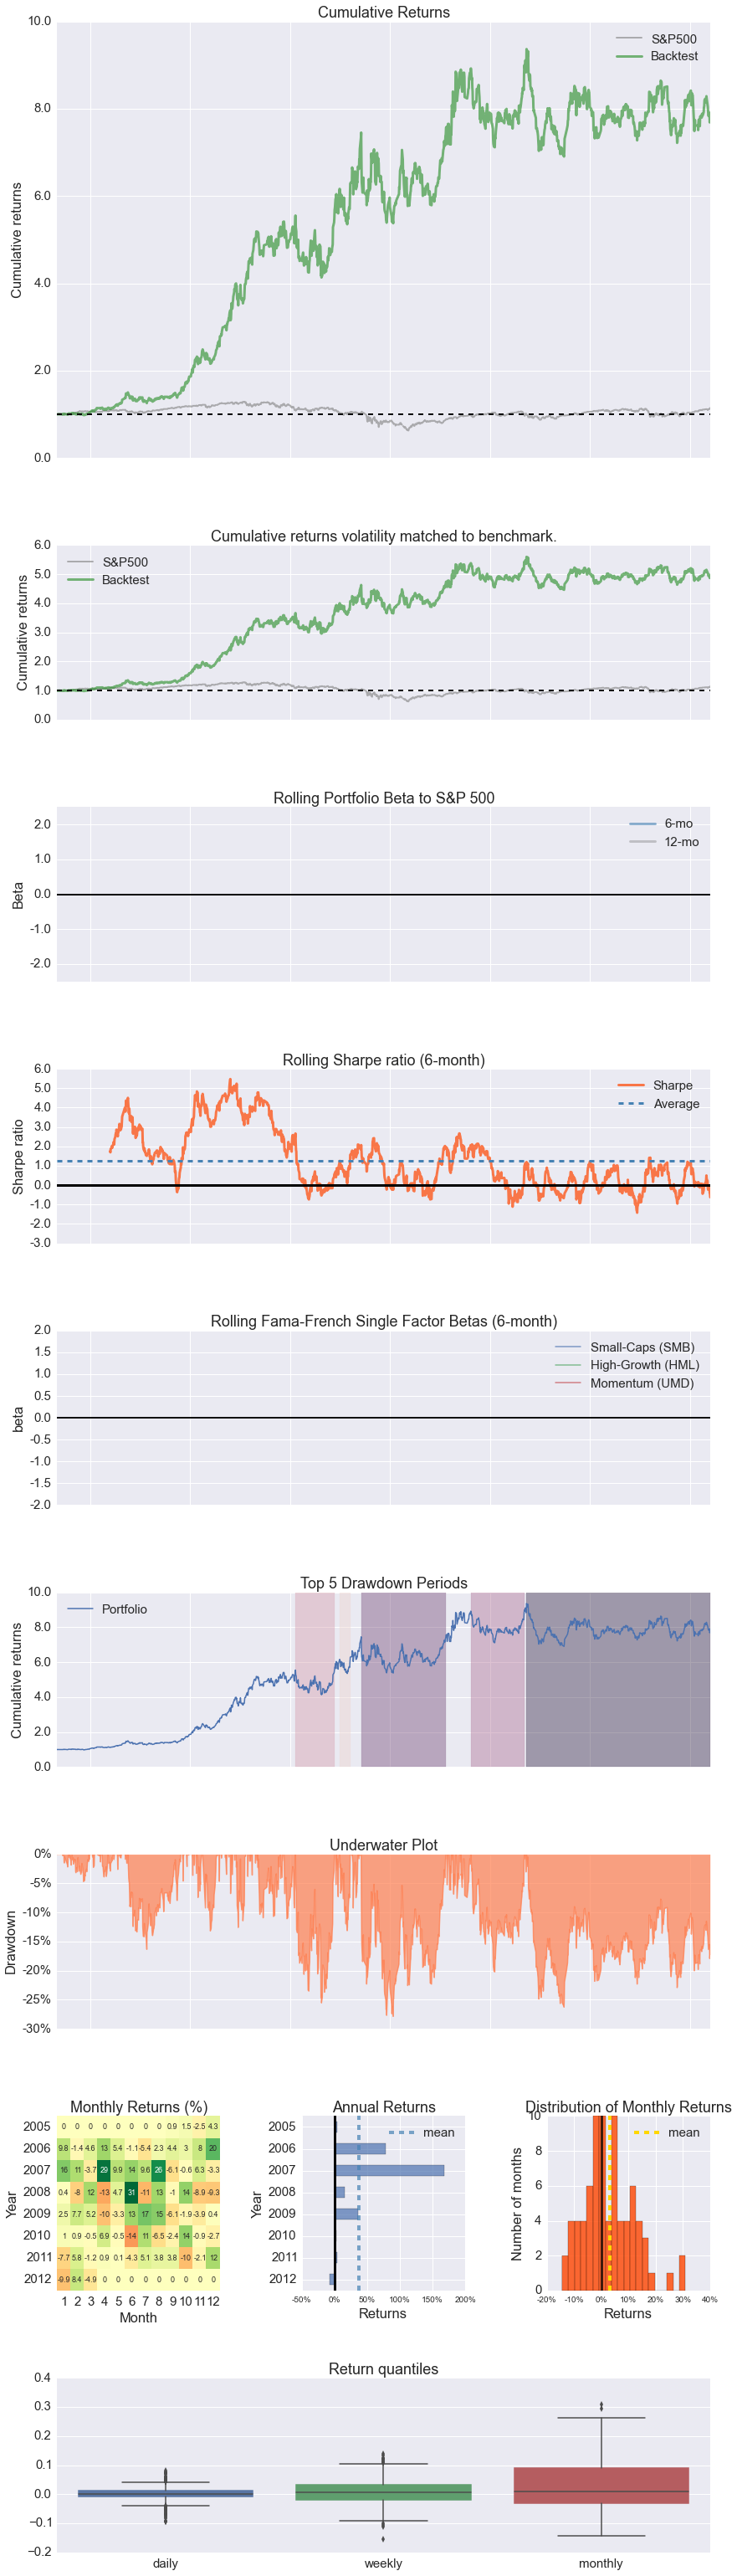

In [16]:
signal = KDJ(data)
returns = Backtest(data,signal['1'])
pf.create_returns_tear_sheet(returns)

### 技术指标系列（二）——ADX平均趋向指标

In [17]:
def ADX(data, n = 14):
    """
    data: original data with open,high,low,close,vol
    n: timeperiod
    """
    
    data['adx'] = talib.ADX(np.array(data.high),np.array(data.low),np.array(data.close),n)#Average Directional Movement Index (Momentum Indicators)
    data['mdi'] = talib.MINUS_DI(np.array(data.high),np.array(data.low),np.array(data.close),n)
    data['pdi'] = talib.PLUS_DI(np.array(data.high),np.array(data.low),np.array(data.close),n)
    signal = pd.DataFrame(index=data.index)
    
    #strategy 1
    """
    当+DI上穿-DI，买入，信号为1
    当+DI下穿-DI，卖空，信号为-1
    """
    signal['1'] = (data['pdi']>data['mdi'])*1 + (data['pdi']<=data['mdi'])*(-1)
    
    return signal

Entire data start date: 2005-09-01
Entire data end date: 2012-03-15


Backtest Months: 75
                   Backtest
annual_return          0.48
annual_volatility      0.32
sharpe_ratio           1.50
calmar_ratio           1.96
stability              0.92
max_drawdown          -0.24
omega_ratio            1.30
sortino_ratio          2.20
skewness              -0.29
kurtosis               2.38
alpha                   NaN
beta                    NaN

Worst Drawdown Periods

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Applications/anaconda/lib/python3.5/site-packages/pyfolio/plotting.py:1346: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  print(drawdown_df.sort('net drawdown in %', ascending=False))



   net drawdown in %  peak date valley date recovery date duration
0              24.20 2009-08-28  2010-04-20    2011-01-14      361
2              21.88 2009-02-13  2009-03-06    2009-07-01       99
3              19.46 2008-12-09  2009-01-14    2009-02-13       49
1              13.90 2012-01-04  2012-02-13           NaT      NaN
4              11.88 2011-01-24  2011-04-20    2011-06-16      104


2-sigma returns daily    -0.038
2-sigma returns weekly   -0.076
dtype: float64


/Applications/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


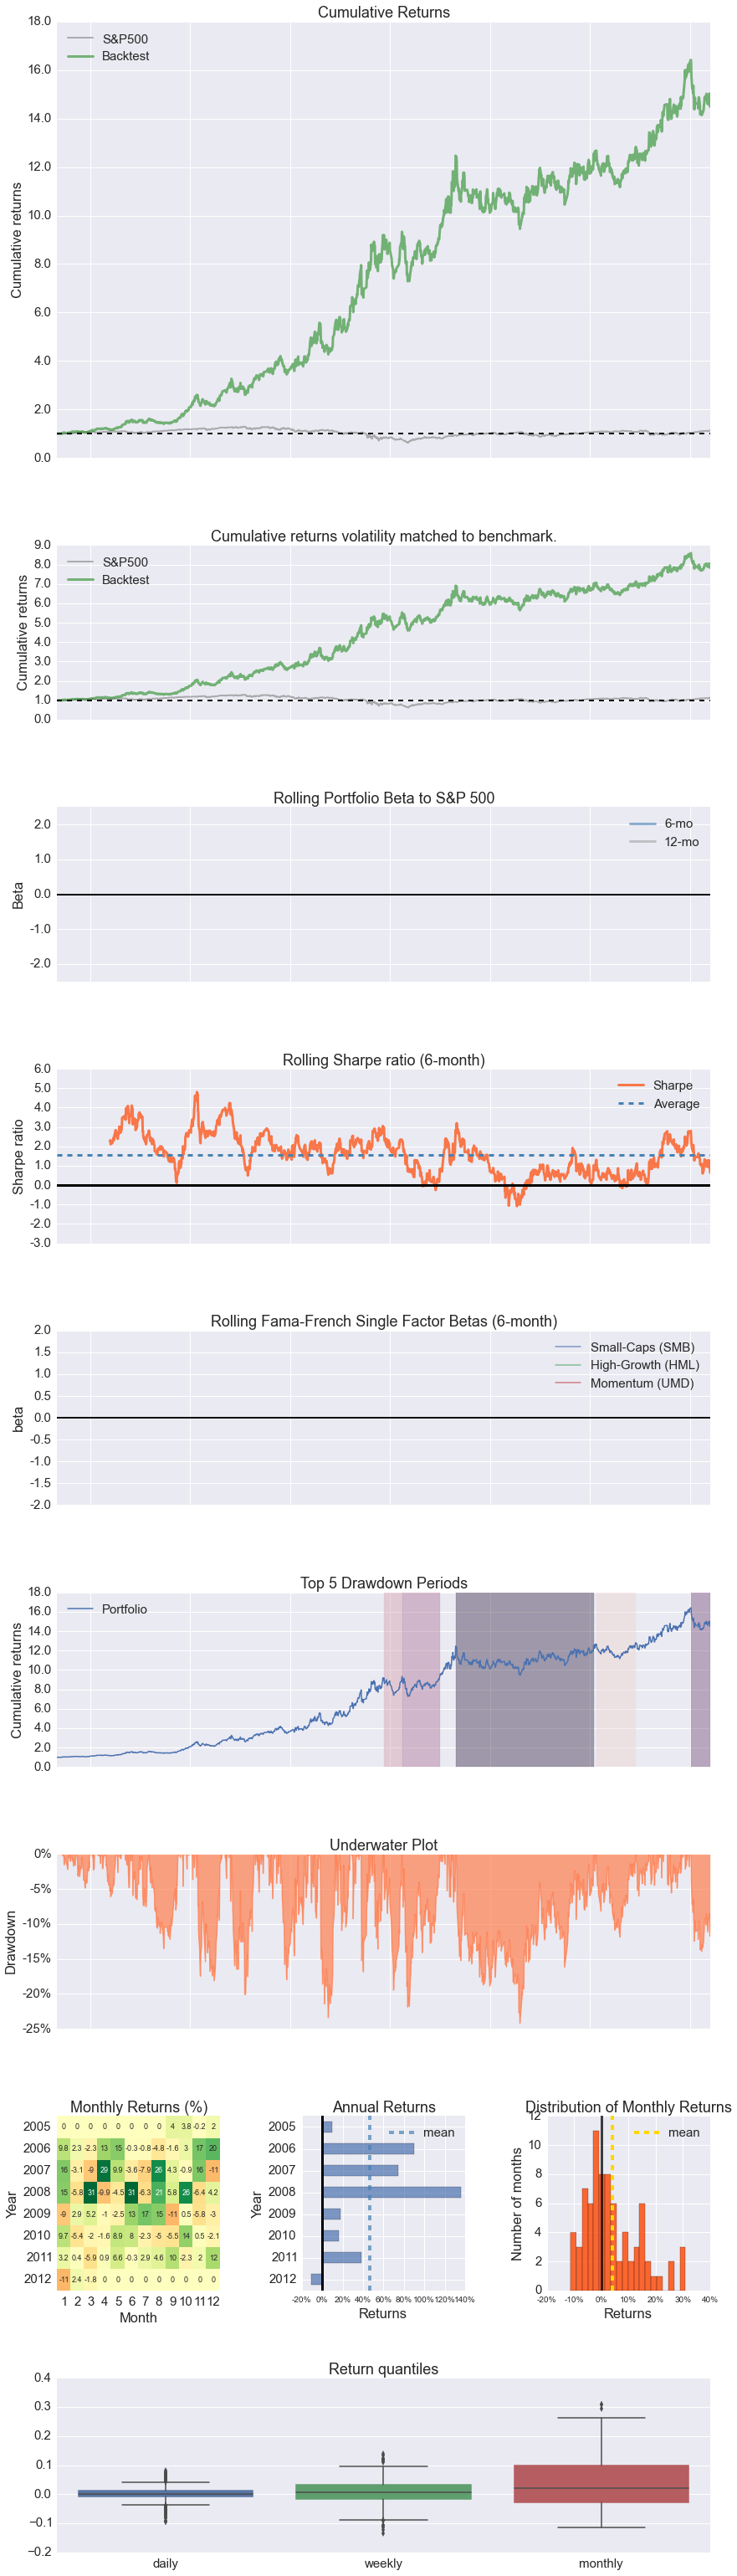

In [18]:
signal = ADX(data)
returns = Backtest(data,signal)
pf.create_returns_tear_sheet(returns)

### 技术指标系列（三）——加入“二次确认”的AROON 阿隆优化指标

In [ ]:
def AROON(data,d=15,up = 50,down= -50, up_up=70 ,down_down = 50):
    """
    data: original data with open,high,low,close,vol
    d: days for calculation
    up and down: threshold for aroon
    up_up and down_down: threshold for aroon_up and aroon_down
    """
    
    data['aroon_dn'],data['aroon_up'] = talib.AROON(np.array(data.high),np.array(data.low),d)
    data['aroon'] = data['aroon_up']-data['aroon_dn']
    signal = pd.DataFrame(index=data.index)
    
    #strategy 1
    """
    当 AROON_UP 上穿70，并且AROON>0，买入，信号为1
    当AROON_DN 上穿70，并且AROON<0，卖空，信号为-1
    当AROON_UP 下穿50，并且AROON<0，卖空，信号为-1
    当AROON_DN 下穿50，并且AROON>0，买入，信号为1
    参数为20
    """
    signal['1'] = ((data['aroon']>0)&\
                  (((data['aroon_up']>70)&(data['aroon_up'].shift(1)<70))|
                  ((data['aroon_up']<50)&(data['aroon_up'].shift(1)>50))))*1+ \
                  ((data['aroon']<0)&(((data['aroon_up']>70)&(data['aroon_up'].shift(1)<70))|
                  ((data['aroon_up']<50)&(data['aroon_up'].shift(1)>50))))*(-1)
    
    #strategy 2
    """
    AROON 上穿50，买入，信号为1
    AROON 下穿-50，卖空，信号为-1
    测得的最优参数为15
    
    for i in range(len(data)):
        if data['aroon'][i]>up:
            if data['aroon_up'][i]>up_up or data['aroon_dn'][i]<down_down:
                data['pred'][i] = 1
        
        elif data['aroon'][i]<down:
            if data['aroon_dn'][i]>up_up or data['aroon_up'][i]<down_down:
                data['pred'][i] = -1
    """            
    return signal

In [ ]:
signal = AROON(data)
returns = Backtest(data,signal)
pf.create_returns_tear_sheet(returns)